## Load libraries

In [5]:
import os
import numpy as np
import pandas as pd
from pprint import pprint as pp

import re
import spacy
import en_core_web_sm
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

from gensim.models import TfidfModel
import gensim.corpora as corpora

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings('ignore')

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from sklearn import manifold
from sklearn.metrics import euclidean_distances

In [6]:
# external software
#mallet_path = "/home/simone/.mallet/mallet-2.0.8/bin/mallet"
mallet_path = '/Users/chashaobao/mallet-2.0.8/bin/mallet'

## Load data

In [7]:
dir_data = '../data/'
file = dir_data + 'DataAnalyst.csv'
col_list = ['Job Title', 'Job Description']
df_job = pd.read_csv(file, usecols=col_list)

# output path
dir_output = '../output/'

## Manipulate data

In [8]:
# change column names
col_old = df_job.columns
col_new = ['title', 'description']
df_job.rename(dict(zip(col_old, col_new)), axis=1, inplace=True)

# remove returns
df_job.loc[:, 'description'] = df_job['description'].str.replace('\n', ' ')
# list of job descriptions
docs = [des.strip().lower() for des in df_job.description]
# hyphen to underscores
docs = [re.sub(r'\b-\b', '_', text) for text in docs]

## Pass documents through spaCy's nlp pipeline

In [9]:
# load language model
nlp = en_core_web_sm.load()

# expand on spaCy's stopwords
stopwords_list = ['data','require','requires','requirement','requirements', 
                  'include','perform','standard','standards','award', 
                  'hypothesis','free','eligibility','able','level', 
                  'location','consumer','year','years','want','job','jobs',
                  'interview','interviews','description','descriptions']
for stopword in stopwords_list:
    nlp.vocab[stopword].is_stop = True

# tokenize text
docs_tokens, tmp_tokens = [], []
for doc in docs:
    tmp_tokens = [token.lemma_ for token in nlp(doc)
                  if not token.is_stop
                  and not token.is_punct
                  and not token.like_num
                  and token.is_alpha]
    docs_tokens.append(tmp_tokens)
    tmp_tokens = []

# take into account bi- and tri-grams
# get rid of common terms
common_terms = [u'of', u'with', u'without', u'and', u'or', u'the', u'a',
                u'not', u'be', u'to', u'this', u'who', u'in']
# find phrases
bigram = Phrases(docs_tokens,
                 min_count=10,
                 threshold=5,   # higher means fewer phrases
                 max_vocab_size=50000,
                 common_terms=common_terms)
trigram = Phrases(bigram[docs_tokens],
                  min_count=10,
                  threshold=5,
                  max_vocab_size=50000,
                  common_terms=common_terms)
# choose tri-grams
docs_phrased = [trigram[bigram[line]] for line in docs_tokens]

# check nlp pipeline
LINE = ''.join(['\n', 79 * '-', '\n'])
print('',
      'Published job description:', docs[0],
      'Tokenized:', docs_tokens[0],
      'Tri-grammed tokenized:', docs_phrased[0],
      sep=LINE, end=LINE)

st pressing injustices of our day?  we are looking to hire a bright, hard_working, and creative individual with strong data management skills and a demonstrated commitment to immigrant's rights. the data analyst will assist with analysis and reporting needs for veras center on immigration and justice (cij), working across its current projects and future vera initiatives.  who we are:  founded in 1961, the vera institute is an independent, non_partisan, nonprofit organization that combines expertise in research, technical assistance, and demonstration projects to assist leaders in government and civil society examine justice policy and practice, and improve the systems people rely on for justice and safety. we study problems that impede human dignity and justice. we pilot solutions that are at once transformative and achievable. we engage diverse communities in informed debate. and we harness the power of evidence to drive effective policy and practice what were doing:  we are helping t

## Text transformation

In [10]:
# create gensim corpora dictionary
dict_docs = Dictionary(docs_phrased)
# convert document into the bag-of-words format
corpus = [dict_docs.doc2bow(doc) for doc in docs_phrased]   

## TF - IDF removal

In [11]:
tfidf = TfidfModel(corpus, id2word=dict_docs)

In [12]:
low_value = 0.02
words = []
words_missing_in_tfidf = []

for i in range(0,len(corpus)):
    bow = corpus[i]
    low_value_words = []
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    drops = low_value_words + words_missing_in_tfidf 
    for item in drops:
        words.append(dict_docs[item])
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
    corpus[i] = new_bow

## Topic modeling - explore model validity

In [13]:
# define function to explore a gamut of competing models
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute coherence scores for various number of topics

    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : List of input texts
    limit      : Max number of topics
    start      : Min number of topics
    step       : Searching step

    Returns:
    --------
    model_list       : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model
                       with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path,
                                                 corpus=corpus,
                                                 num_topics=num_topics,
                                                 id2word=dictionary,
                                                 random_seed=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model,
                                        #texts=texts,   # should pass corpus fro u_mas
                                        corpus=corpus,
                                        dictionary=dictionary,
                                        coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [14]:
limit, start, step = 30, 10, 1
model_list, coher_vals = compute_coherence_values(dictionary=dict_docs,
                                                  corpus=corpus,
                                                  texts=docs_phrased,
                                                  start=start,
                                                  limit=limit,
                                                  step=step)

In [15]:
coher_vals

[-1.459530027881362,
 -1.5160110555697315,
 -1.5221088207600444,
 -1.5504475695921942,
 -1.6221637894957726,
 -1.5608685128286444,
 -1.5914929777143336,
 -1.5897449965374357,
 -1.5827814983392632,
 -1.6385737715862345,
 -1.6146031643130296,
 -1.6423129683942126,
 -1.6250969875939598,
 -1.6764891577918697,
 -1.6624661495927622,
 -1.6914835951880314,
 -1.6605937284824945,
 -1.691228763491705,
 -1.649586629265589,
 -1.6853251353506806]

## Plot coherence scores

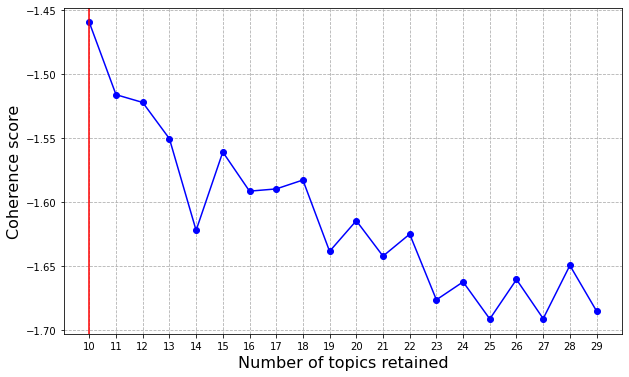

In [17]:
# data series
X = range(10, 30, 1)
Y = coher_vals

# create figure
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
# plot data
ax.plot(X, Y, marker='o', color='b', ls='-')
# axes
ax.set_xlabel("Number of topics retained",fontsize=16)
ax.set_ylabel("Coherence score",fontsize=16)
ax.set_xticks(np.arange(10, 30, 1))
# reference line
ax.axvline(x=10, ymin=0, ymax=1, color='r')
# grid
ax.grid(True, ls='--')

# plt.savefig(dir_output + 'coherence_values_umass.pdf', 
#             transparent=True,
#             bbox_inches='tight',
#             pad_inches=0)

plt.show()

## Get suggested number of topics to retain

In [18]:
n_topics = 10

In [19]:
# model estimation
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path,
                                              corpus=corpus,
                                              num_topics=n_topics,
                                              id2word=dict_docs,
                                              random_seed=123)

In [20]:
# print results
lda_mallet.print_topics(num_topics=n_topics,
                        num_words=10)

[(0,
  '0.026*"position" + 0.019*"information" + 0.018*"application" + 0.016*"program" + 0.016*"support" + 0.016*"system" + 0.013*"require" + 0.010*"service" + 0.009*"provide" + 0.009*"education"'),
 (1,
  '0.023*"financial" + 0.017*"security" + 0.012*"status" + 0.011*"disability" + 0.010*"risk" + 0.009*"service" + 0.009*"employment" + 0.008*"contract" + 0.008*"employee" + 0.007*"provide"'),
 (2,
  '0.036*"ability" + 0.029*"report" + 0.018*"ensure" + 0.017*"process" + 0.016*"management" + 0.015*"maintain" + 0.014*"quality" + 0.011*"reporting" + 0.011*"information" + 0.010*"require"'),
 (3,
  '0.042*"knowledge" + 0.039*"skill" + 0.038*"strong" + 0.032*"database" + 0.029*"sql" + 0.023*"system" + 0.021*"report" + 0.019*"analyst" + 0.018*"management" + 0.018*"query"'),
 (4,
  '0.051*"business" + 0.042*"analysis" + 0.041*"analytic" + 0.026*"tool" + 0.016*"develop" + 0.014*"visualization" + 0.013*"dashboard" + 0.013*"tableau" + 0.013*"analytical" + 0.013*"model"'),
 (5,
  '0.024*"product" + 

## Result visualization with pyLDAvis

In [21]:
# translate topic modeling outcome
lda_mallet_g = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_mallet)

# visualize the outcome of the retained model
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_mallet_g, corpus, dict_docs, sort_topics=False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.070258 -0.237523       1        1   9.975546
1     -0.068822 -0.260949       2        1   8.810703
2      0.221166 -0.013339       3        1  11.526078
3      0.233255  0.103644       4        1   8.178938
4      0.046956  0.240400       5        1  11.062676
5     -0.278608  0.156252       6        1  10.702884
6     -0.172070  0.076173       7        1   9.743572
7     -0.248153 -0.048315       8        1   9.845181
8      0.049114 -0.135664       9        1   9.513801
9      0.146904  0.119322      10        1  10.640620, topic_info=           Term         Freq        Total Category  logprob  loglift
361    business  5052.000000  5052.000000  Default  30.0000  30.0000
318        team  2936.000000  2936.000000  Default  29.0000  29.0000
11     analysis  2856.000000  2856.000000  Default  28.0000  28.0000
655      client  1951.000000  1951.000000  Default  27.0000  27.0000
349    analytic  2387.000000  2387.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
777  technology   516.762446  1603.331548  Topic10  -4.5373   1.1082
313     support   596.653313  2272.680938  Topic10  -4.3935   0.9031
331        user   339.789005   680.789185  Topic10  -4.9565   1.5456
123       exist   285.180058   468.661268  Topic10  -5.1317   1.7437
61      complex   286.191335   874.890959  Topic10  -5.1282   1.1231

[920 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
0         3  0.781427                ability
0         4  0.218884                ability
890       7  0.989318      ability_multitask
1         1  0.243071                 access
1         2  0.065976                 access
...     ...       ...                    ...
339       6  0.555828                  world
339       8  0.443916                  world
2561      5  0.991901                wrangle
4605      4  1.003259  write_present_finding
3984      2  0.998371                      â

[1413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

## Get term-to-topic probabilities

In [22]:
# get top 10 terms per topic
top_terms_line = lda_mallet_g.show_topics(num_topics=n_topics, 
                                          num_words=10)

# rearrange data on top 10 terms per topic
top_terms_m = []
for i in top_terms_line:
    topic_num = i[0]
    prob_terms = i[1].split('+')
    for term_sort, term in enumerate(prob_terms):
        weight = float(term.split('*')[0])
        term = term.split('*')[1].strip('"| ')
        top_terms_m.append([topic_num, term_sort, weight, term])

df_term = pd.DataFrame(top_terms_m)

# rename columns
old_names = [0, 1, 2, 3]
new_names = ['topic_n', 'term_sort', 'weight', 'term']
cols = dict(zip(old_names, new_names))
df_term.rename(columns=cols, inplace=True)

df_term.set_index(['term_sort', 'topic_n'], inplace=True)
df_term = df_term.unstack()

In [23]:
# sideways table
df_h = pd.DataFrame()

for i in range(n_topics):
    terms = df_term['term'][i]
    weights = df_term['weight'][i]
    weights = pd.Series(['( %s )' % j for j in weights])
    df_h = pd.concat([df_h, terms, weights], axis=1)

In [24]:
col_old_topic = df_h.columns
col_new_topic = [['Topic_%d'%i, ' '] for i in range(1,11)]
col_new_topic = [item for sublist in col_new_topic for item in sublist]

In [25]:
df_h.rename(dict(zip(col_old_topic, col_new_topic)), axis=1, inplace=True)
df_h.columns.values[0] = "Topic_1"

In [26]:
df_h.T

,0,1,2,3,4,5,6,7,8,9
Topic_1,position,information,application,program,support,system,require,service,provide,education
,( 0.026 ),( 0.019 ),( 0.018 ),( 0.016 ),( 0.016 ),( 0.016 ),( 0.013 ),( 0.01 ),( 0.009 ),( 0.009 )
Topic_2,financial,security,status,disability,risk,service,employment,contract,employee,provide
,( 0.023 ),( 0.017 ),( 0.012 ),( 0.011 ),( 0.01 ),( 0.009 ),( 0.009 ),( 0.008 ),( 0.008 ),( 0.007 )
Topic_3,ability,report,ensure,process,management,maintain,quality,reporting,information,require
,( 0.036 ),( 0.029 ),( 0.018 ),( 0.017 ),( 0.016 ),( 0.015 ),( 0.014 ),( 0.011 ),( 0.011 ),( 0.01 )
Topic_4,knowledge,skill,strong,database,sql,system,report,analyst,management,query
,( 0.042 ),( 0.039 ),( 0.038 ),( 0.032 ),( 0.029 ),( 0.023 ),( 0.021 ),( 0.019 ),( 0.018 ),( 0.018 )
Topic_5,business,analysis,analytic,tool,develop,visualization,dashboard,tableau,analytical,model
,( 0.051 ),( 0.042 ),( 0.041 ),( 0.026 ),( 0.016 ),( 0.014 ),( 0.013 ),( 0.013 ),( 0.013 ),( 0.013 )


In [27]:
# write data to file
#file_latex = dir_output + 'prob_term_to_topic.tex'
df_h.T.to_latex(file_latex, index=True)

## Get topic-to-document probabilities

In [28]:
# get transformed corpus as per the LDA model
transf_corpus = lda_mallet_g.get_document_topics(corpus,
                                                 minimum_probability=0)

# rearrange data on document-topic pairs probabilities
doc_topics_m = []
for id, doc in enumerate(transf_corpus):
    for topic in np.arange(0, n_topics, 1):
        topic_n = doc[topic][0]
        topic_prob = doc[topic][1] 
        doc_topics_m.append([id, topic, topic_prob])

df_doc = pd.DataFrame(doc_topics_m)

# rename columns
old_names = [0, 1, 2]
new_names = ['doc_id', 'topic_n', 'prob']
cols = dict(zip(old_names, new_names))
df_doc.rename(columns=cols, inplace=True)

In [29]:
df_doc

,doc_id,topic_n,prob
0,0,0,0.407138
1,0,1,0.098383
2,0,2,0.040081
3,0,3,0.042539
4,0,4,0.030775
...,...,...,...
22525,2252,5,0.145364
22526,2252,6,0.081498
22527,2252,7,0.079266
22528,2252,8,0.184472


In [30]:
# dominant topic
gr = df_doc.groupby('doc_id')
df_doc.loc[:, 'max'] = gr['prob'].transform(np.max)
# use binary 0/1 to find the topic with the highest probability
df_doc.loc[:, 'first_topic'] = 0
df_doc.loc[df_doc['prob'] == df_doc['max'], 'first_topic'] = 1

first_topic = df_doc.loc[df_doc['first_topic'] == 1]

In [31]:
first_topic[['doc_id', 'topic_n', 'max']]

,doc_id,topic_n,max
0,0,0,0.407138
12,1,2,0.347884
25,2,5,0.332773
37,3,7,0.307468
45,4,5,0.403528
...,...,...,...
22482,2248,2,0.174473
22494,2249,4,0.219091
22509,2250,9,0.276400
22514,2251,4,0.312069


In [32]:
# arrange data as contingency table
df_doc = df_doc.pivot_table(index='doc_id', 
                            columns='topic_n', 
                            values='prob', 
                            aggfunc=np.mean)

In [33]:
# write data to file
file_doc = dir_output + 'prob_topic_to_document.csv'
#df_doc.to_csv(file_doc, index=True)

## MDS on the transformed corpus

In [34]:
# center features (doc-topic probabilities) data
X = df_doc.values
X -= X.mean()

# get similarity matrix
sims = euclidean_distances(X)

# mds model
seed = np.random.seed(123)
mds = manifold.MDS(n_components=2, 
                   max_iter=3000, 
                   eps=1e-9, 
                   random_state=seed,
                   dissimilarity="precomputed", 
                   n_jobs=1)

# get MDS positions
pos = mds.fit(sims).embedding_

In [35]:
# get data frame
pos = pd.DataFrame(pos, columns=('x1', 'x2'))
pos.loc[:, 'doc_id'] = np.arange(0, len(df_doc))

# merge MDS positions and most important topic by document
df_pos = pd.merge(pos, first_topic[['doc_id', 'topic_n']], 
                  on='doc_id', how='inner')

In [36]:
df_pos

,x1,x2,doc_id,topic_n
0,-0.348796,0.074749,0,0
1,-0.171132,0.241695,1,2
2,-0.164495,-0.244372,2,5
3,0.097526,-0.236498,3,7
4,-0.072357,-0.345062,4,5
...,...,...,...,...
2248,0.021894,0.066104,2248,2
2249,-0.082570,-0.013154,2249,4
2250,0.130213,0.120832,2250,9
2251,-0.187273,-0.044302,2251,4


In [37]:
# write data to file
file_position = dir_output + 'mds_positions.csv'
#df_pos.to_csv(file_position, index=False)

## Labeling

In [38]:
# load company information
col_list_labels = ['Job Title','Size','Salary Estimate','Sector']
df_label = pd.read_csv(file, usecols=col_list_labels)
# manipulate data
col_old = df_label.columns
col_new = ['title','salary','size','sector']
df_label.rename(dict(zip(col_old, col_new)), axis=1, inplace=True)

In [39]:
# add salary indicators
def income_distribution(string):
    if string =='-1':
        income = 'Not known Salary'
    else:
        string_list = re.findall('[\d]+',string)
        average = (int(string_list[0]) + int(string_list[1]))/2
        if average <= 35:
            income = 'Low Salary'
        elif 35 < average <= 65:
            income = 'Lower Moderate Salary'
        elif 65 < average <= 130:
            income = 'Upper Moderate Salary'
        else:
            income = 'High Salary'
    return income

df_label['salary_tolabel'] = df_label['salary'].apply(income_distribution)
# add dummy variables 
df_dummy =pd.get_dummies(df_label['salary_tolabel'], drop_first = False)
#df_label = df_label.drop('salary_tolabel',axis=1)
df_label = pd.concat([df_dummy,df_label],axis=1)

In [40]:
# add company size indicators
df_label['size_tolabel'] = df_label['size']
df_label['size_tolabel'] = df_label['size'].str.replace('-1','Unknown employees')
df_label['size_tolabel'] = df_label['size'].str.replace('Unknown','Unknown employees')
# add dummy variables 
df_dummy = pd.get_dummies(df_label['size_tolabel'], drop_first = False)
#df_label = df_label.drop('size_tolabel',axis=1)
df_label = pd.concat([df_dummy,df_label],axis=1)

In [41]:
# add sector indicators
def sectors(string):
    choose = ['Information Technology','Finance','Health Care','Business Services']
    if string not in choose:
        string = 'Other Sectors'
    return string

df_label['sector_toLabel'] = df_label['sector'].apply(sectors)
# add dummy variables
df_dummy = pd.get_dummies(df_label['sector_toLabel'], drop_first = False)
#df_label = df_label.drop('sector_toLabel',axis=1)
df_label = pd.concat([df_dummy,df_label],axis=1)

In [42]:
df_label = df_label.drop('-1',axis=1)

In [43]:
df_label.head(3).T

,0,1,2
Business Services,0,0,0
Finance,0,0,0
Health Care,0,1,0
Information Technology,0,0,1
Other Sectors,1,0,0
1 to 50 employees,0,0,0
10000+ employees,0,1,0
1001 to 5000 employees,0,0,1
201 to 500 employees,1,0,0
5001 to 10000 employees,0,0,0


## Plot topics across sectors

In [44]:
df_sector = first_topic[['doc_id','topic_n']].reset_index(drop=True)
df_sector['sector'] = df_label['sector_toLabel'].values

In [45]:
df_sector.head()

,doc_id,topic_n,sector
0,0,0,Other Sectors
1,1,2,Health Care
2,2,5,Information Technology
3,3,7,Information Technology
4,4,5,Other Sectors


In [46]:
df_barchart = df_sector.groupby(['topic_n','sector'])['sector'].count().unstack().fillna(0)

for col in df_barchart.columns:
    df_barchart.loc[:,col] = round((df_barchart.loc[:,col] * 100 / df_barchart.loc[:,col].sum()), 3)

df_barchart = df_barchart.T

In [47]:
df_barchart.head()

topic_n,0,1,2,3,4,5,6,7,8,9
sector,,,,,,,,,,
Business Services,4.962,8.015,10.305,12.595,14.504,9.542,3.817,15.649,3.817,16.794
Finance,2.959,24.260,11.834,2.367,10.651,15.976,3.550,10.651,1.775,15.976
Health Care,3.311,1.987,13.907,3.311,13.907,9.934,1.325,3.974,43.046,5.298
Information Technology,2.281,5.614,6.491,19.123,13.509,18.246,5.614,7.368,2.982,18.772
Other Sectors,10.846,5.364,14.660,6.317,16.925,13.111,5.125,5.721,10.608,11.323


<Figure size 1080x720 with 0 Axes>

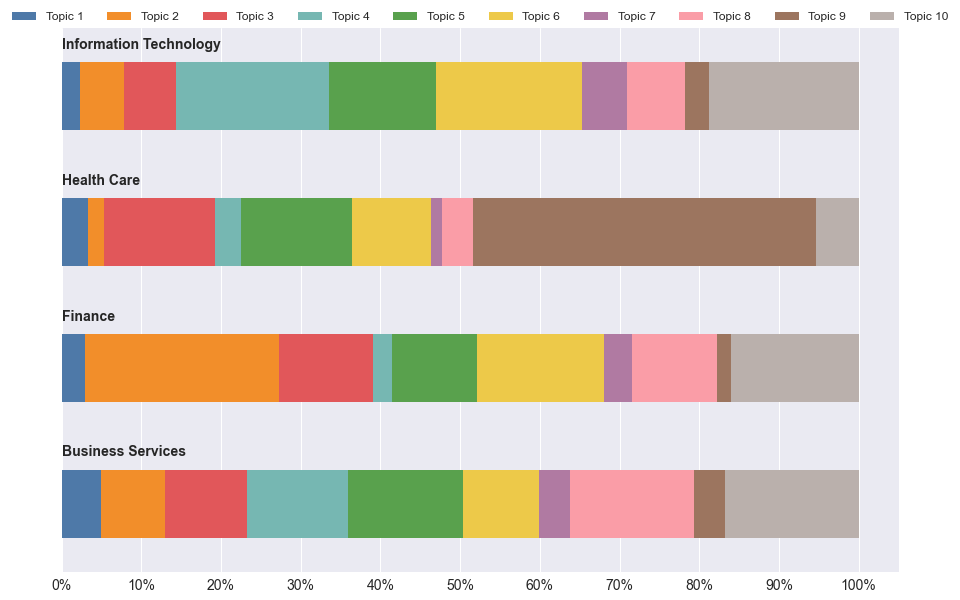

In [48]:
plt.style.use('seaborn')
plt.figure(figsize=(15,10))
df_barchart.iloc[:-1,:].plot(kind='barh',stacked=True,figsize=(15,10),color=['#4e79a8','#f28e2a','#e1575a','#76b7b2','#59a14d','#edc949','#b07aa2','#fa9da7','#9c755f','#bab0ac'])

plt.ylabel('',size=18,weight=550)
plt.xlabel('',size=22,weight=850)

plt.xticks(range(0,110,10),[str(x)+'%' for x in range(0,110,10)],size=14)
plt.yticks([])

plt.text(0,3.35,'Information Technology',size=14,weight=650)
plt.text(0,2.35,'Health Care',size=14,weight=650)
plt.text(0,1.35,'Finance',size=14,weight=650)
plt.text(0,0.35,'Business Services',size=14,weight=650)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=12,
           ncol=10, fancybox=False, shadow=True,labels=['Topic '+str(x) for x in range(1,11)])

# plt.savefig(dir_output + 'barchart_sector.pdf',
#             bbox_inches='tight',
#             pad_inches=0)

plt.show()

## Plot topics across company sizes

In [49]:
df_size = first_topic[['doc_id','topic_n']].reset_index(drop=True)
df_size['size'] = df_label['size_tolabel'].values

In [50]:
df_size.head()

,doc_id,topic_n,size
0,0,0,201 to 500 employees
1,1,2,10000+ employees
2,2,5,1001 to 5000 employees
3,3,7,201 to 500 employees
4,4,5,501 to 1000 employees


In [51]:
df_barchart_size = df_size.groupby(['topic_n','size'])['size'].count().unstack().fillna(0)

for col in df_barchart_size.columns:
    df_barchart_size.loc[:,col] = round((df_barchart_size.loc[:,col] * 100 / df_barchart_size.loc[:,col].sum()), 3)

df_barchart_size = df_barchart_size.T

<Figure size 1080x720 with 0 Axes>

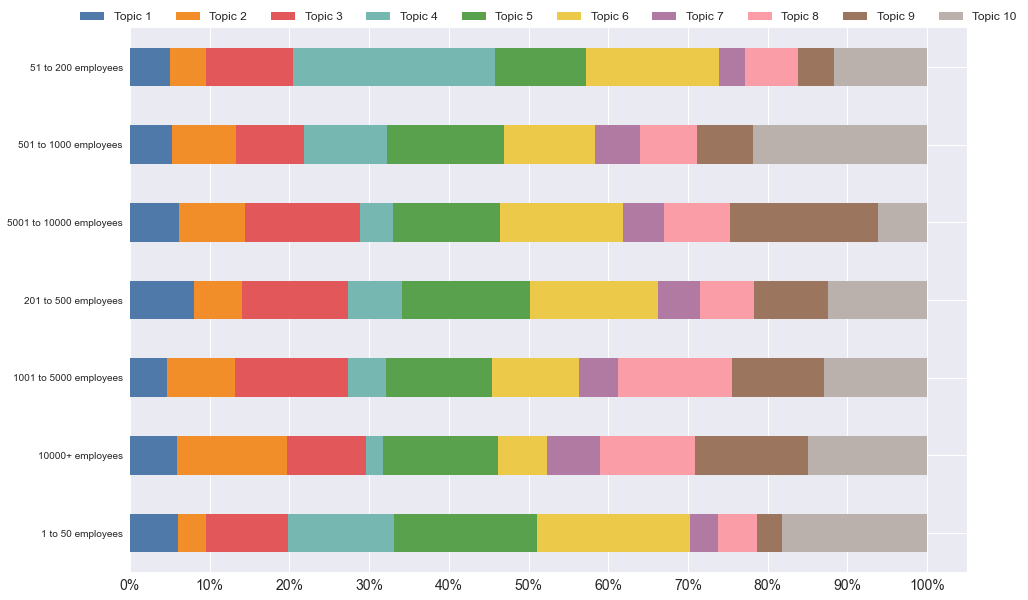

In [52]:
plt.style.use('seaborn')
plt.figure(figsize=(15,10))
df_barchart_size.iloc[1:-1,:].plot(kind='barh',stacked=True,figsize=(15,10),color=['#4e79a8','#f28e2a','#e1575a','#76b7b2','#59a14d','#edc949','#b07aa2','#fa9da7','#9c755f','#bab0ac'])

plt.ylabel('',size=18,weight=550)
plt.xlabel('',size=22,weight=850)

plt.xticks(range(0,110,10),[str(x)+'%' for x in range(0,110,10)],size=14)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), fontsize=12,
          ncol=10, fancybox=False, shadow=True,labels=['Topic '+str(x) for x in range(1,11)])

# plt.savefig(dir_output + 'barchart_size.pdf',
#             bbox_inches='tight',
#             pad_inches=0)

plt.show()

## Plot MDS

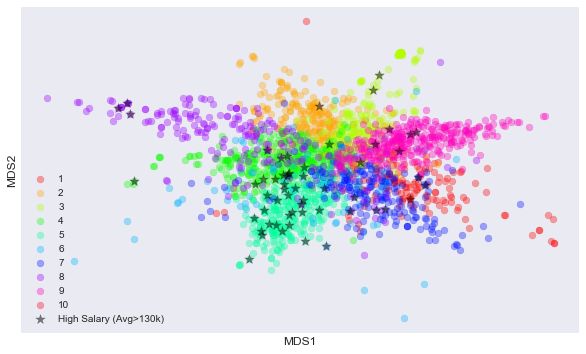

In [56]:
unique_topics = np.arange(1, n_topics+1, 1)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
# colors
cmap = cm.hsv(np.linspace(0, 1, len(unique_topics)))
# labels for topics
labels = ['%s' % i for i in unique_topics]
for topic, label, color in zip(unique_topics, labels, cmap):
    x1 = df_pos.loc[df_pos['topic_n'] == topic, 'x1']
    x2 = df_pos.loc[df_pos['topic_n'] == topic, 'x2']
    ax.scatter(x1, x2, 
                color=color, alpha=0.35, 
                label=label)
# label for company information
#condition = (df_label['High Salary'] == 1) & (df_label['title'].str.contains('Data Analyst',flags=re.I))
condition = df_label['High Salary'] == 1
X1 = df_pos.loc[condition, 'x1']
X2 = df_pos.loc[condition, 'x2']
ax.scatter(X1, X2, 
            color='black', alpha=0.5,
            marker='*', s=100,
            label='High Salary (Avg>130k)')
# axes
ax.set_xlabel('MDS1',fontsize=12)
ax.set_ylabel('MDS2',fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
# legend
ax.legend(loc='lower left',frameon=False)
# frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig(dir_output + 'mds_topics_highsalary.pdf',
#             transparent=True,
#             bbox_inches='tight',
#             pad_inches=0)

# send plot to the screen
plt.show()

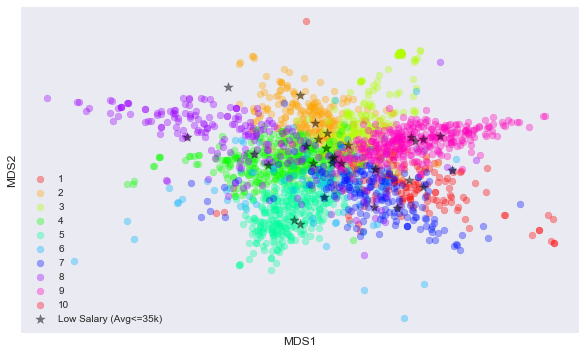

In [57]:
unique_topics = np.arange(1, n_topics+1, 1)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
# colors
cmap = cm.hsv(np.linspace(0, 1, len(unique_topics)))
# labels for topics
labels = ['%s' % i for i in unique_topics]
for topic, label, color in zip(unique_topics, labels, cmap):
    x1 = df_pos.loc[df_pos['topic_n'] == topic, 'x1']
    x2 = df_pos.loc[df_pos['topic_n'] == topic, 'x2']
    ax.scatter(x1, x2, 
                color=color, alpha=0.35, 
                label=label)
# label for company information
condition = df_label['Low Salary'] == 1
X1 = df_pos.loc[condition, 'x1']
X2 = df_pos.loc[condition, 'x2']
ax.scatter(X1, X2, 
            color='black', alpha=0.5,
            marker='*', s=100,
            label='Low Salary (Avg<=35k)')
# axes
ax.set_xlabel('MDS1',fontsize=12)
ax.set_ylabel('MDS2',fontsize=12)
ax.set_xticks([])
ax.set_yticks([])
# legend
ax.legend(loc='lower left',frameon=False)
# frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# plt.savefig(dir_output + 'mds_topics_lowsalary.pdf',
#             transparent=True,
#             bbox_inches='tight',
#             pad_inches=0)

# send plot to the screen
plt.show()